In [ ]:
import sys
import random
import importlib
import datetime
from os import path
import math
import collections
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (5, 4)

In [178]:
from IPython.display import HTML, display as disp, Markdown as md, Latex

HTML("""
<style type="text/css">
body{
    width:600px /* or you can also set 90% or 900px*/
    column-width: 600px
}
p {
    font-size:10px;
}
</style>
""")

In [97]:
import core as co
import hist_data as hd

hd.set_hist_data(data_count=None)


forecast:
direction: sell-buy
min profit [PIP]: 3.10
panic value [PIP]: 0.19



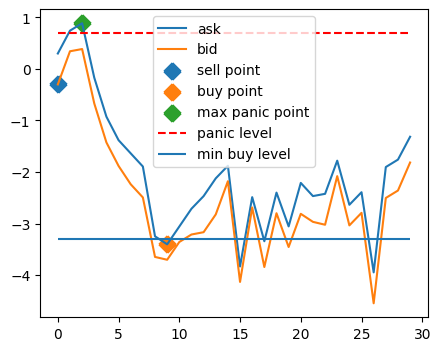

In [99]:
import tokenizer as to
import forecast as fo
importlib.reload(fo)
import piecewise_fit as ls
importlib.reload(ls)
importlib.reload(co)

FORECAST_THRESHOLD = co.config.FORECAST_THRESHOLD
PANIC_THRESHOLD = co.config.PANIC_THRESHOLD
FORECAST_WINDOW = co.config.FORECAST_WINDOW
RISK_FACTOR = 0.7

shift = random.randint(0, 2000)
forecast = fo.Forecast(
    hd.DATA[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD)
print(forecast)
forecast.plot(True)
# [0.000114, 0.000227, 0.000455, 0.00091, 0.00182, 0.00364, 0.00728, 0.0146]


## Gambler

In [212]:
import gambler as gs
_ = importlib.reload(hd)
_ = importlib.reload(fo)
_ = importlib.reload(gs) 

In [51]:
hd.set_hist_data(data_count=None)
oracle = fo.Oracle(hd.ForexProvider())

advice: sell-buy, profit: 6.4e-04, min. profit: 3.0e-04


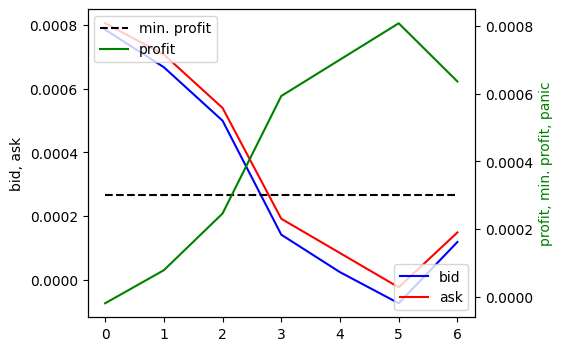

In [77]:
class SimpleStrategy:
    """Envelope for strategy definition of ``Gambler`` objects.
    Must have a ``strategy`` method.
    """
    def __init__(self, risk_factor=0.9):
        self.risk_factor = risk_factor

    def strategy(self, _):
        """Strategy definition
        Parameters
        ----------
        _ : Reference to the Gambler object.

        Returns
        -------
        continue : If set, continue transaction, finish otherwise.
        """
        if (_.profit >= _.min_profit) and _.max_profit is None:
            _.max_profit = -sys.float_info.max

        if _.max_profit is not None:
            _.max_profit = max(_.max_profit, _.profit)
            if _.profit < _.max_profit * self.risk_factor:
                return False
        return True

g = gs.gambler(forex_prediction=oracle.prediction, plot=True, strategy_class=SimpleStrategy)

In [8]:
hd.set_hist_data(data_count=None, verbose=False)
oracle = fo.Oracle(hd.ForexProvider())

profits = []
timestamps = []
times = []

while True:
    g = gs.gambler(forex_prediction=oracle.prediction, min_profit=3e-4, risk_factor=0.8)
    if (g is None) or g.endofdata:
        break
    profits.append(g.profit)
    timestamps.append(g.timestamp)
    times.append(g.times[-1])

END OF DATA


In [9]:
trans_count = len(profits)
profits = np.array(profits)
total = sum(profits)
print(f'trans. count: {trans_count}')
print(f'total profit: {total:.1e}')
print(f'mean profit: {total / trans_count:.1e}')


trans. count: 27508
total profit: 1.0e+01
mean profit: 3.8e-04


min_profit=4e-3, risk_factor=0.8
trans. count: 22
total profit: 8.7e-02
mean profit: 4.0e-03

min_profit=3e-4, risk_factor=0.8
trans. count: 27508
total profit: 1.0e+01
mean profit: 3.8e-04

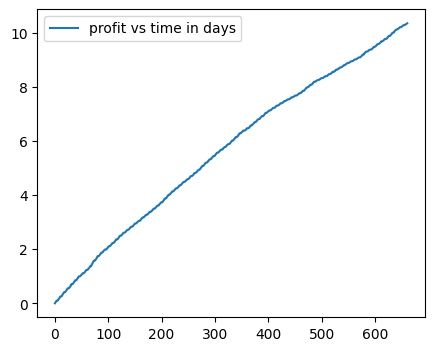

In [129]:
cumprofit = profits.cumsum()
timestamps = np.array(timestamps, dtype=int)
days = (timestamps - timestamps[0]) / 60 / 60 / 24
plt.plot(days, cumprofit, label='profit vs time in days')
plt.legend()
plt.show()

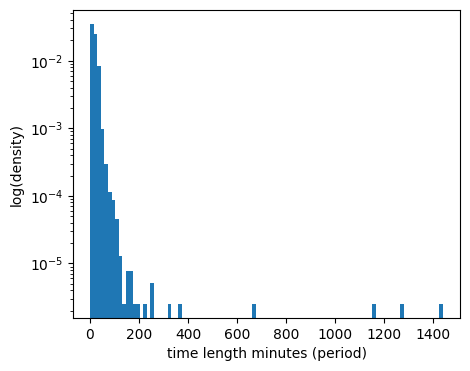

In [130]:
plt.hist(times, bins=100, density=True, log=True)
plt.xlabel('time length minutes (period)')
plt.ylabel('log(density)')
plt.show()

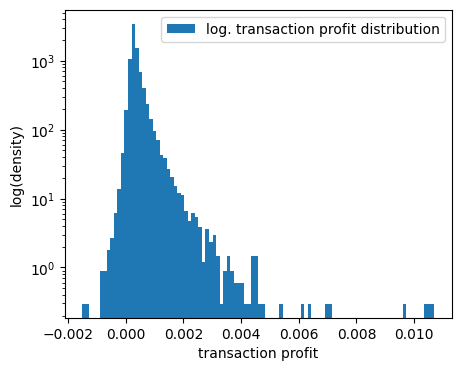

In [131]:
plt.hist(profits, bins=100, density=True, log=True, label='log. transaction profit distribution')
plt.xlabel('transaction profit')
plt.ylabel('log(density)')
plt.legend()
plt.show()

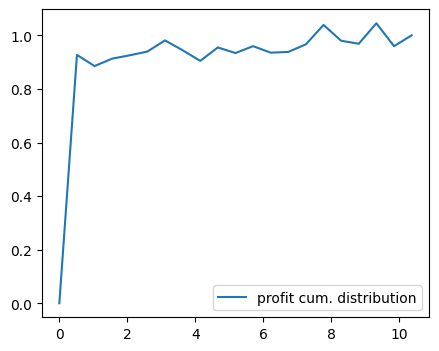

In [132]:
cumprofit = profits.cumsum()
hist, bin_edges = np.histogram(cumprofit, bins=20, )
plt.plot(bin_edges, np.insert(hist / hist[-1], 0, 0), label='profit cum. distribution')
plt.legend()
plt.show()

In [ ]:
forex = [(_[0], (_[1][1][0][0] + _[1][1][1][0]) / 2.) for _ in list(hd.DICT_DATA.items())]

In [180]:
forex[0]

(1672781640.0, -0.00921663598471889)

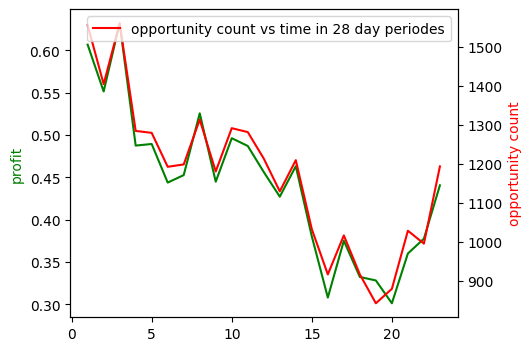


Profit kumulowany okresowe w czasie od 2023:01:03 21:36 do 2024:10:25 13:00. Idealnie 
koreluje się z okresowym natężeniem okazji do profitu, odwrotnie proporcjonalnym 
do temperatury forex. Tak jest, ponieważ transakcje są otwierane tylko wtedy, gdy
w określonym czasie zmiana poziomów osiągnie określoną wartość.


In [179]:
import time

time_begin = time.strftime("%Y:%m:%d %H:%M", time.gmtime(timestamps[0]))
time_end = time.strftime("%Y:%m:%d %H:%M", time.gmtime(timestamps[-1]))

prediction_times = [_[0] for _ in list(oracle.predictions().items()) if _[1][0] is not None ]


def profit_over_day_count(day_count=7):
    minutes = (timestamps - timestamps[0]) // 60
    period = 60 * 24 * day_count
    period_count = 1
    index_l = 0
    time_periodes = []
    profit_sums = []
    opportunity_counts = []


    while True:
        index_u = np.argmin(minutes < period_count * period)
        if index_u == 0:
            break
        time_periodes.append(period_count)
        profit_sums.append(sum(profits[index_l: index_u]))
        opportunity_counts.append(len(prediction_times[index_l: index_u]))
        period_count += 1
        index_l = index_u

    _, plt_profit = plt.subplots()

    plt_profit.plot(time_periodes, profit_sums, color='green',
             label=f'profit vs time in {day_count} day periodes')
    plt_profit.set_ylabel('profit', color='green')
    
    plt_opp = plt_profit.twinx()
    plt_opp.plot(time_periodes, opportunity_counts, color='red',
             label=f'opportunity count vs time in {day_count} day periodes')
    plt_opp.set_ylabel('opportunity count', color='red')
    
    plt.legend()
    plt.show()

profit_over_day_count(28)

disp(md(f"""
Profit kumulowany okresowe w czasie od {time_begin} do {time_end}. Idealnie 
koreluje się z okresowym natężeniem okazji do profitu, odwrotnie proporcjonalnym 
do temperatury forex. Tak jest, ponieważ transakcje są otwierane tylko wtedy, gdy
w określonym czasie zmiana poziomów osiągnie określoną wartość.
"""))

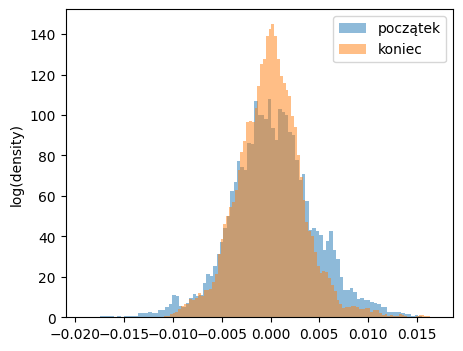


Różnica pomiędzy początkiem i końcem okresu.


In [211]:
forex = np.array(forex)
noise = [_[1] for _ in forex]

begining = noise[:len(noise) // 4]
end = noise[len(noise) // 4:]
plt.hist(begining, bins=100, density=True, log=False, alpha=0.5, label='początek')
plt.xlabel('')
plt.ylabel('log(density)')
plt.hist(end, bins=100, density=True, log=False, alpha=0.5, label='koniec')
plt.legend()
plt.show()

disp(md(f"""
Różnica pomiędzy początkiem i końcem okresu.
"""))

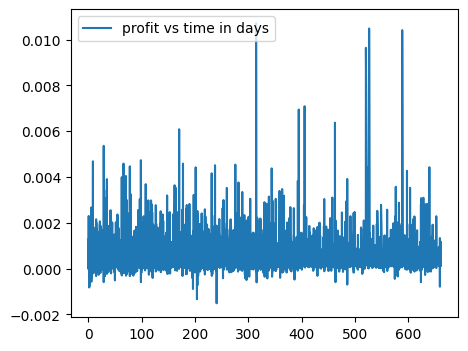

In [122]:
plt.plot(days, profits, label='profit vs time in days')
plt.legend()
plt.show()

disp(md("""
"""))

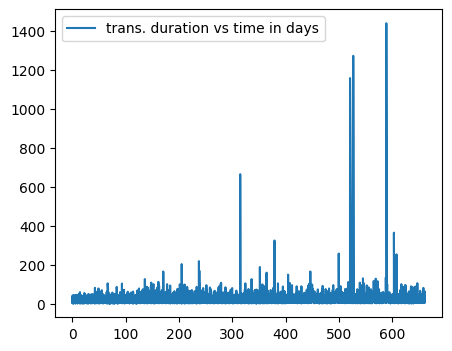

In [20]:
days = (timestamps - timestamps[0]) / 60 / 60 / 24
plt.plot(days, times, label='trans. duration vs time in days')
plt.legend()
plt.show()

In [214]:
class SimpleStrategy:
    """Envelope for strategy definition of ``Gambler`` objects.
    Must have a ``strategy`` method.
    """
    def __init__(self, risk_factor=0.9):
        self.risk_factor = risk_factor

    def strategy(self, _):
        """Strategy definition
        Parameters
        ----------
        _ : Reference to the Gambler object.

        Returns
        -------
        continue : If set, continue transaction, finish otherwise.
        """
        if (_.profit >= _.min_profit) and _.max_profit is None:
            _.max_profit = -sys.float_info.max

        if _.max_profit is not None:
            _.max_profit = max(_.max_profit, _.profit)
            if _.profit < _.max_profit * self.risk_factor:
                return False
        return True

    hd.set_hist_data(data_count=None)
    oracle = fo.Oracle(hd.ForexProvider())    
    
    gs.run(
        forex_prediction=oracle.prediction, 
        strategy_class=SimpleStrategy, 
        time_step=5, 
        verbose=True)  

END OF DATA
profit: 9.1e+01, trans. count: 248780
